# River Discharge time series analysis

*Adapted from ('Time Series Analysis & Climate Change')*

### ⚒ Set NB configuration and libraries

In [1]:
%load_ext autoreload

%autoreload 2

%matplotlib inline

In [2]:
import requests
import json
from oatlib import sensor, method, oat_utils
from dateutil import parser
import matplotlib.pyplot as plt
from statistics import stdev

from dateutil import parser, relativedelta
from datetime import datetime, tzinfo, timedelta
import dateutil


### ⚒ Create a sensor and upload data

data       float64
quality      int64
dtype: object

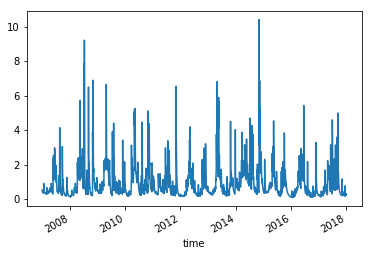

In [3]:
Q_VED = sensor.Sensor(
    name='CAVERGNO',
    lat=46.34300,
    lon=8.60875,
    alt=455,
    tz= '+02:00',
    prop='air:temperature',
    unit='celsius'
)
Q_VED.ts_from_csv(
    'data/Q_VED_ISO_20180101000000000000.dat',
    qualitycol=2,
    sep=',',
    skiprows=1
)
Q_VED.ts['data'].plot()
Q_VED.ts.dtypes

### ⚒ Generate the Monthly mean

/home/maxi/.local/lib/python3.6/site-packages/oatlib/method.py:125: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...)..apply(<func>).ffill()
  fill_method=self.fill, limit=self.limit)


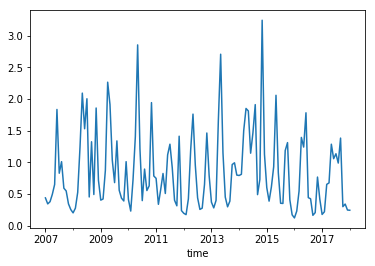

In [4]:
Q_VED_M = Q_VED.process(method.Resample(freq='MS',how='mean',fill='ffill',how_quality='max'))
Q_VED_M.ts.dtypes
Q_VED_M.ts['data'].plot()

### ⚒ Plot data and Monthly data

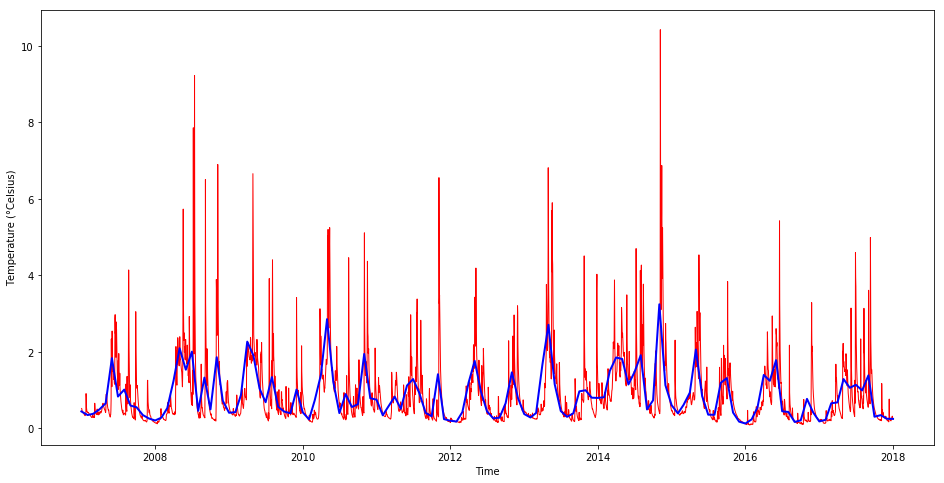

In [5]:
#T_CAV_M.ts['data'].plot(figsize=(10,8))

# Create figure, title and plot data
plt.figure(figsize=(16,8))
plt.xlabel('Time')
plt.ylabel('Temperature (°Celsius)')
plt.plot(Q_VED.ts['data'], color='#ff0000', linewidth=1)
plt.plot(Q_VED_M.ts['data'], color='#0000ff', linewidth=2)

### ⚒ Calculate monthly Q anomalies

First we need to calculate the monthly discharge averages.   
We use the "groupby" method that create subsamples of data that has the same month number and then we apply the "mean".


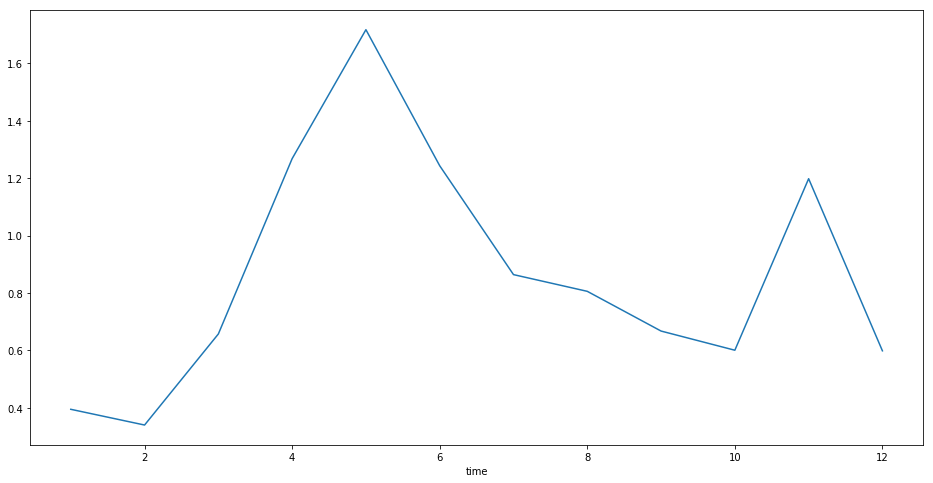

In [6]:
monthly_averages = Q_VED_M.ts['data'].groupby(Q_VED_M.ts.index.month).mean()
monthly_averages.plot(figsize=(16,8))

Then, We create a new sensor that is a copy of the "Q_VED" and iterate along the rows   
setting the "data" column as the deviation from the corresponding month mean (calculate above)

Finally we plot the calculate anomalies, specifying the plot size, the axis names and the line color and width

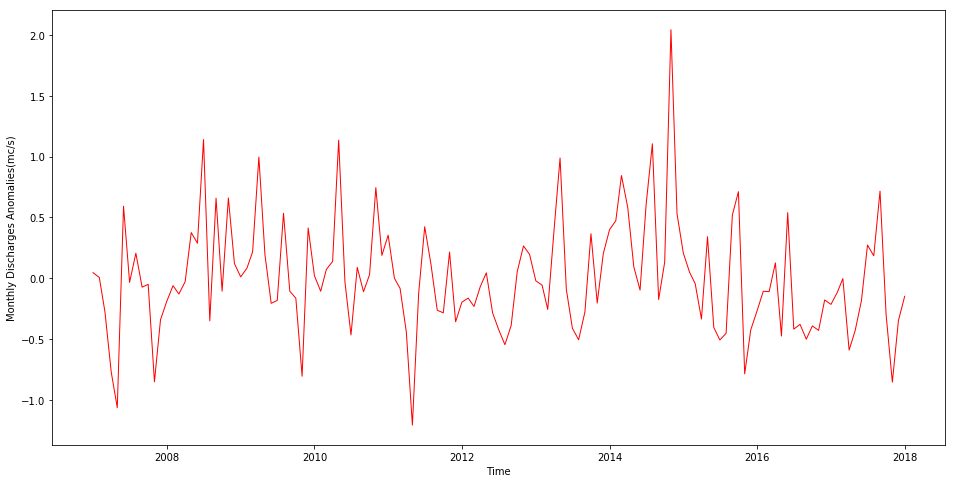

In [7]:
Q_VED_M_AN = Q_VED_M.copy()

for index, row in Q_VED_M_AN.ts.iterrows():
    Q_VED_M_AN.ts.loc[index,'data'] = row['data'] - monthly_averages[index.month]
    
plt.figure(figsize=(16,8))
plt.xlabel('Time')
plt.ylabel('Monthly Discharges Anomalies(mc/s)')
plt.plot(Q_VED_M_AN.ts['data'], color='#ff0000', linewidth=1)

## ⚒ Forecasting with Prophet
[Prophet](https://www.youtube.com/watch?v=pOYAXv15r3A&feature=youtu.be) is a forecasting tool developed by Facebook to quickly forecast time series data.

The Prophet algorithm is an additive model, which means that it detects the following trend and seasonality from the data first, then combine them together to get the forecasted values.

   * Overall Trend
   * Yearly, Weekly, Daily Seasonality
   * Holiday Effect

And this means that by looking at the trend and the seasonality that are detected by the Prophet, we can gain quite a lot of useful insights from the model.

**NOTE**: <br>
Prophet depends on Pandas, but it has not been still released with bug fixes due to later Pandas 1.0.0 release. <br>
Either downgrade to Pandas 0.25.3, compile from github or wait for next pip release

In [8]:
#import the library
try:
    from fbprophet import Prophet
except:
    if hasattr(sys, 'real_prefix'):
        !pip install plotly --upgrade 
        !pip install holidays==0.9.12
        !pip install pystan
        !pip install fbprophet
    else: 
        !pip install plotly --upgrade --user
        !pip install holidays==0.9.12 --user
        !pip install pystan --user
        !pip install fbprophet --user
        from fbprophet import Prophet

import pandas as pd

In [9]:

from fbprophet import Prophet

### ⚒ Create a data frame as prophet requires

In [10]:
# Create a new DataFrame with which we will create/train our Prophet model 
t_prophet = pd.DataFrame()
t_prophet['ds'] = Q_VED.ts.index
t_prophet['y'] = Q_VED.ts['data'].values

### ⚒ Instantiate model and fit to data

In [11]:
m = Prophet()
m.fit(t_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### ⚒ Generate future dataframe containing predictions (we are doing this for 2 years into the future)

In [12]:
future = m.make_future_dataframe(freq='m', periods=2*12)
forecast = m.predict(future)

**Forecast contain the predicted value (yhat).**   
Additionally, it shows lower/upper bounds of uncertainty (yhat_lower and yhat_upper).   
The ‘Uncertainty Interval’, similar to Confidence Interval, indicates the range the model thinks the forecasted values could be.  
The default is 80%, which can be configurable from the property "interval_width" 
e.g.: 

    forecast = Prophet(interval_width=0.95).fit(df).predict(future)
    


In [13]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4036,2019-08-31,0.246155,-0.747902,1.194995
4037,2019-09-30,0.222976,-0.727533,1.179714
4038,2019-10-31,0.617475,-0.351530,1.575290
4039,2019-11-30,0.374057,-0.581758,1.379206
4040,2019-12-31,0.076796,-0.898022,1.012122


### ⚒ Plot the resulting forecast

Plottingthe forecast produce a graph of the observations, the forecasted values and the uncertanty interval.   
Past observations, show the goodness of prediction compared to data and highlight "outliers".   


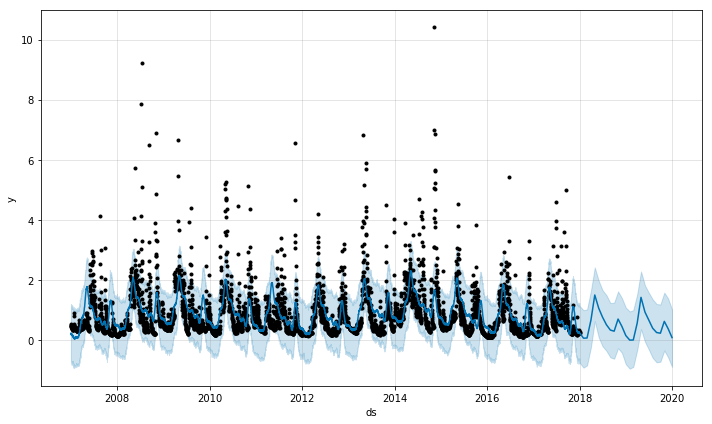

In [14]:
fig1 = m.plot(forecast)

### ⚒ Plot the components

Plotting the different found additive components illustrete:
* Trend = This is a line but the slope changes at something called ‘change points’, which are the times where the trend changes compared to the trend in the previous period.
* Seasonality (Yearly, Weekly, Daily) = These lines identify the components of different found seasonality effects 

**Note:** the y scale which indicates the relative additive factor

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
forecast.tail()